# Training a Neural Net

- Now that we have an undertanding of what *training* is, let's try it out!
- I'll use **Keras**, a wrapper that takes care of the low-level configuration of **TensorFlow**
- Only need the concepts of *neurons*, *layers*, *activtion function* etc. to build a NN in Keras 

# Training requires **data**

- Kaggle Higgs ML challenge

   - In 2014, Kaggle (online ML community) partnered with ATLAS to stage an ML competition
   - Teams were given signal ($H \rightarrow\tau \tau$) and background ($Z \rightarrow \tau \tau \;, t\bar{t} \;, W \rightarrow e/\mu$) simulation
   - The best classification performance (best *Approximate Median Significance*) wins!

    # I'll use this dataset to demo the training of a classification NN


In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  

In [4]:
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s,u,0.259892
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s,u,0.020956
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b,u,53.284258
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b,u,22.971060


# Data pre-processing

- extract -
   - variables that discriminate between signal and background (*features*)
   - labels that indicate whether the event is *signal* or *background*
   - weights that tell us how much that event should count in the loss function... Why?

- arrange this data in separate synchronous dataframe columns (or numpy arrays)

# Data pre-processing

- Split data into approximately equally-sized *training* and *test* set
    - training set used to directly alter weights and biases and minimise loss function
    - test set used to check performace and generalisability of network as batches passed through network
    
    
- loss(training) and loss(test) sets decreases as training proceeds
    - eventually, loss(training) $<$ loss(test) as network learns statitical fluctuations of training set
    - This is **over-training** and needs to be avoided at all costs... Why is it so bad?
        - In Keras usually terminate training once loss(training) $<<$ loss(test)

In [5]:
#extract features, labels, and event-weights
Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
y=np.ravel(labels)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))

weights = df['Weight']
weights=np.ravel(weights) 

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.33, random_state=42, shuffle=True)

Number of signal events = 279560
Number of background events = 538678


# How do we weight MC events in general?

- we require our histograms to:
   - represent our expected data under some hypothesis

-  therefore the final weight must include:
   - the cross section of the process, the luminosity
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors
   
$$ w_{final}  = \sigma * \mathcal{L} * w_{MC} * (w_{trigger} * w_{b-tagging} \dots etc.) $$

# What about when we are training an ML algorithm?

- **optimally**, we want our training simulation to look like our data

-  therefore the training simulation should include:
   - the cross section of the process??, ~~the luminosity of the dataset~~
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors 

# In the case of a rare signal, this approach can lead to an undeperforming NN !

- NN aims to discriminate between labelled data classes: S and B ($t = 1,0$)
- The NN output, $p(x)$ (discriminator), is the predicted probability for the S class 
- Training NN minimises a **loss function**  
- The *binary cross-entropy* for weighted events becomes:
$$ C_{B} = \sum_i - \big[ ( t* \ln p(x_i))  + (1-t)*(\ln (1-p(x_i)) ) \big] * w_{i}$$

# weighting strategies
- 1. **ignore weights altogether**: 
     - the relative contribution of the S and B classes to the loss function will depend on how many MC events of each class you generated!! ¯\_(ツ)_/¯
     - relative contributions of processes within mixed background class won't correspond to the SM! ¯\_(ツ)_/¯
- 2. **use $w_{final}$**
   - theoretically correct *weighted mixture* of processes
   - rare signal hardly contributes to the loss function at all! 
      - classifying $\approx$ all events as background would give $\approx$ 100% accuracy
- 3. **use $w_{final}$: but give signal events a final constant weight such that** $$\sum w^b_i = \sum w^s_i$$

In [19]:
df_train = pd.DataFrame()
df_train["label"] = y_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

print(sigSumWeights)

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

print(modsigSumWeights)


final_weights_train = df_train["weights"]

463.6826625268901
275359.8189364471


# Define network 'architecture'

- How many neurons, how many layers?
- What activation function? What loss function?

In [7]:
model = Sequential()
model.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model.add(Dense(15, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   
model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)

Epoch 1/8
5483/5483 [==============================] - 4s 637us/step - loss: 6.0452
Epoch 2/8
5483/5483 [==============================] - 4s 639us/step - loss: 0.5839
Epoch 3/8
5483/5483 [==============================] - 4s 662us/step - loss: 0.5462 0s - lo
Epoch 4/8
5483/5483 [==============================] - 4s 655us/step - loss: 0.4738
Epoch 5/8
5483/5483 [==============================] - 4s 655us/step - loss: 0.4501
Epoch 6/8
5483/5483 [==============================] - 3s 628us/step - loss: 0.4097
Epoch 7/8
5483/5483 [==============================] - 3s 626us/step - loss: 0.3996
Epoch 8/8
5483/5483 [==============================] - 3s 627us/step - loss: 0.3929


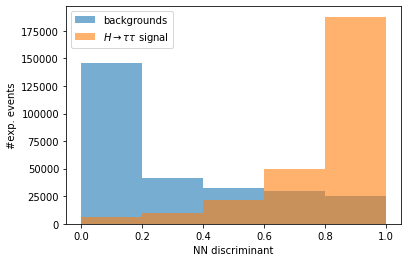

In [20]:
# plot discriminator values for "train" set
pred_train = model.predict(X_train)

dfNN = pd.DataFrame()
dfNN["labels"] = y_train
dfNN["predictions"] = pred_train
dfNN["weights"] = final_weights_train

signalVals = dfNN[dfNN['labels']== 1] 
backgroundVals = dfNN[dfNN['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

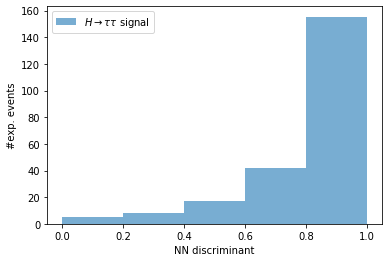

In [15]:
# plot discriminator values for "test" set
pred_test = model.predict(X_test)

dfNN = pd.DataFrame()
dfNN["labels"] = y_test
dfNN["predictions"] = pred_test
dfNN["weights"] = weights_test

signalVals = dfNN[dfNN['labels']== 1] 
backgroundVals = dfNN[dfNN['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

#bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

In [9]:
def getSig(sigHist, bkgHist):

    #extract signifcance vs. discriminant.
    bins = sigHist[1]
    nSig = sigHist[0]
    nBkg = bkgHist[0]

    binCentres = (bins[:-1] + bins[1:]) / 2
    width = bins[1] - bins[0]
    sigmasNN = np.array([])
    sigmasVar = np.array([])

    for x in range(0,len(binCentres)):
        indices = [x, (len(binCentres)-1)] 
        if (nBkg[indices].sum() != 0):
            sigma = (nSig[indices].sum()) / ( np.sqrt(nBkg[indices].sum() + nBkg[indices].sum() ))
        else:
            sigma = 0.001
        sigmasNN = np.append(sigmasNN, sigma)
        
    return binCentres, sigmasNN

No handles with labels found to put in legend.


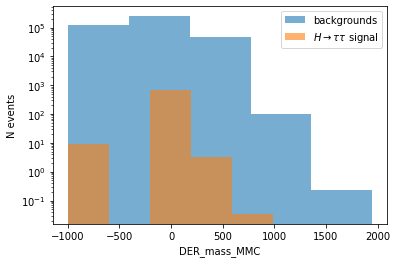

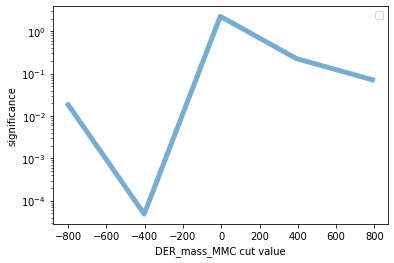

In [10]:
signalVals = df[df['Label']== "s"] 
backgroundVals = df[ df['Label']== "b"]

for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals[var], bins=5, weights=backgroundVals["Weight"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals[var], bins=5, weights=signalVals["Weight"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.legend() 
        plt.yscale('log')
        plt.show()

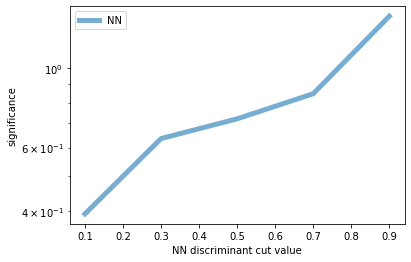

In [13]:
#make comparison plot
fig, ax1 = plt.subplots()
plt.xlabel("NN discriminant cut value")
plt.ylabel("significance")
plt.yscale('log')
binCentres, sigmasNN = getSig(sigHistNN, bkgHistNN)

ax1.plot(binCentres, sigmasNN, label="NN", lw=5, alpha=0.6)
plt.legend()    
plt.show()